In [1]:
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from itertools import islice
import glob
from PIL import Image
import cv2 as cv
import random

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv(r"/content/drive/MyDrive/sign_data/train_data.csv")

In [ ]:
data

,Item 1,Item 2,Label
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
...,...,...,...
23201,031/02_031.png,031/03_031.png,0
23202,031/02_031.png,031/12_031.png,0
23203,031/02_031.png,031/11_031.png,0
23204,031/02_031.png,031/06_031.png,0


In [ ]:
base_dir=r"/content/drive/MyDrive/sign_data"
train_dir=r"/content/drive/MyDrive/sign_data/train"

In [ ]:
train_datagen= tf.keras.preprocessing.image.ImageDataGenerator()


In [ ]:
def img_paths(data,dir):

  originals=data["Item 1"]
  pairs=data["Item 2"]

  image_paths=[]
  i=0
  for original,pair in zip(originals,pairs):
    path_original=os.path.join(train_dir,original)
    path_pair=os.path.join(train_dir,pair)
    image_paths.append((path_original,path_pair))

  labels=data["Label"]
  labels=np.array(labels)
  labels=labels.astype('float32')
  return image_paths,labels

In [ ]:
image_paths,label=img_paths(data,train_dir)

In [ ]:
from sklearn.model_selection import train_test_split
def get_paths(image_paths,label,split=0):
  train,test,y_train,y_test=train_test_split(image_paths,label,test_size=split,shuffle=True,random_state=42)
  return train,test,y_train,y_test

train_paths,valid_paths,y_train,y_valid=get_paths(image_paths,label,split=0.2)

In [ ]:
import numpy as np
import random
from tensorflow.keras.utils import Sequence
from skimage.color import rgb2gray

class SiameseDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        batch_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        X1, X2, y = [], [], []

        for i in range(len(batch_paths)):
            img_path1, img_path2 = batch_paths[i]
            label = batch_labels[i]

            # Load and preprocess images
            image1 = self.load_and_preprocess_image(img_path1)
            image2 = self.load_and_preprocess_image(img_path2)

            X1.append(image1)
            X2.append(image2)
            y.append(label)

        return [np.array(X1), np.array(X2)], np.array(y)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def load_and_preprocess_image(self, img_path):
        # Load and preprocess your image here
        # You can use libraries like OpenCV or PIL for loading and preprocessing
        # Make sure to resize and normalize the images as required
        # Example:
        image = cv.imread(img_path)
        image = cv.resize(image, self.image_size)
        image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
        image=cv.cvtColor(image,cv.COLOR_RGB2GRAY)
        _,image=cv.threshold(image,128,255,cv.THRESH_OTSU+cv.THRESH_BINARY_INV)
        image = image / np.std(image)  # Normalize the pixel values



        # Return the preprocessed image
        return image

# Example usage:



In [ ]:
  # Example labels (1 for similar pairs, 0 for dissimilar pairs)
batch_size = 64
image_size = (155, 220)  # Set the desired image size
train_data_generator = SiameseDataGenerator(train_paths, y_train, batch_size, image_size)
valid_data_generator = SiameseDataGenerator(valid_paths, y_valid, batch_size, image_size)

# You can now use data_generator for training your Siamese network using model.fit()

In [ ]:
def display_img(data_generator,count=0):
  enough=False
  for batch_x, batch_y in data_generator:
      print(np.array(batch_x).shape)
      for i in range(len(batch_x[0])):
        image_1=batch_x[0][i]
        image_2=batch_x[1][i]

        label = batch_y[i]

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_1,cmap='gray')
        plt.title(f"Image 1 - Label: {label}")

        plt.subplot(1, 2, 2)
        plt.imshow(image_2,cmap='gray')
        plt.title(f"Image 2 - Label: {label}")

        plt.show()
        if i==count:
          enough=True
          break
      if enough==True:
        break

      print(f"Batch X1 shape: {batch_x[0].shape}, Batch X2 shape: {batch_x[1].shape}, Batch y shape: {batch_y.shape}")

In [ ]:
def siamese_network():
    inputs=tf.keras.Input(shape=(155,220,1))
    x=tf.keras.layers.Conv2D(96,(11,11),strides=1,padding='valid',input_shape=(155,220,1),activation='relu')(inputs)
    x=tf.keras.layers.Lambda(lambda x:tf.nn.local_response_normalization(x,depth_radius=2,bias=2, alpha=0.0001, beta=0.75))(x)
    x=tf.keras.layers.MaxPooling2D((3,3),strides=2)(x)

    x=tf.keras.layers.Conv2D(256,(5,5),strides=1,padding='valid',activation='relu')(x)
    x=tf.keras.layers.Lambda(lambda x:tf.nn.local_response_normalization(x,depth_radius=2,bias=2, alpha=0.0001, beta=0.75))(x)
    x=tf.keras.layers.MaxPooling2D((3,3),strides=2)(x)
    x=tf.keras.layers.Dropout(0.3)(x)

    x=tf.keras.layers.Conv2D(384,(3,3),strides=1,padding='valid',activation='relu')(x)

    x=tf.keras.layers.Conv2D(256,(3,3),strides=1,padding='valid',activation='relu')(x)
    x=tf.keras.layers.MaxPooling2D((3,3),strides=2)(x)
    x=tf.keras.layers.Dropout(0.3)(x)

    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(1024,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)

    x=tf.keras.layers.Dense(128,activation='relu')(x)

    return tf.keras.Model(inputs=inputs,outputs=x)


In [ ]:
def euclidian_distance(encodings):
    encode_a,encode_b=encodings
    sum_squares=tf.keras.backend.sum(tf.keras.backend.square(encode_a-encode_b),axis=1, keepdims=True)
    d=tf.keras.backend.sqrt(tf.keras.backend.maximum(sum_squares,tf.keras.backend.epsilon()))

    return d

def euclidian_shape(shapes):
    shape1,shape2=shapes
    return (shape1[0],1)

In [ ]:
base_model=siamese_network()

In [ ]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 155, 220, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 145, 210, 96)      11712     
                                                                 
 lambda (Lambda)             (None, 145, 210, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 104, 96)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 100, 256)      614656    
                                                                 
 lambda_1 (Lambda)           (None, 68, 100, 256)      0         
                                                             

In [ ]:
input_a=tf.keras.layers.Input(shape=(155,220,1), name='left_input')
input_b=tf.keras.layers.Input(shape=(155,220,1), name='right_input')

vect_a=base_model(input_a)
vect_b=base_model(input_b)

In [ ]:
output=tf.keras.layers.Lambda(euclidian_distance,name='output_layer',output_shape=euclidian_shape)([vect_a,vect_b])
model=tf.keras.Model([input_a,input_b],output)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  8326905   ['left_input[0][0]',          
                                                          6          'right_input[0][0]']         
                                                                                                  
 output_layer (Lambda)       (None, 1)                    0         ['model[0][0]',         

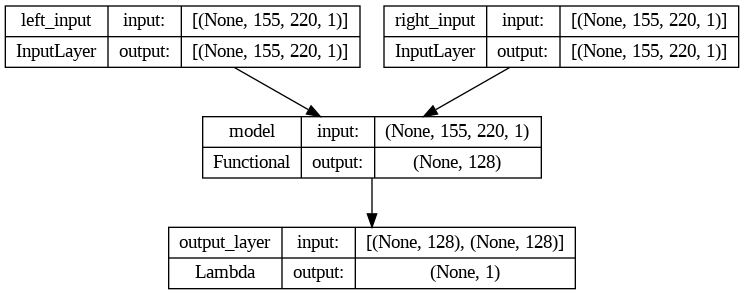

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True,to_file='outer-model.png')

In [ ]:
#Contrastive loss:-L = (1-Y) * ||x_i - x_j||^2 + Y * max(0, m - ||x_i - x_j||^2) #x_i and x_j are the vector encodings we receive from our siamese model
def contrastive_loss_margin(margin): #This is a wrapper surrounding our self defined loss function which helps to pass parameters to the loss function
    def contrastive_loss(y_true,y_pred):
        square_pred=tf.keras.backend.square(y_pred)  #||x_i - x_j||^2

        margin_square=tf.keras.backend.square(tf.keras.backend.maximum(margin-y_pred,0)) #max(0, m - ||x_i - x_j||^2) m=margin

        return tf.keras.backend.mean(y_true*margin_square+(1-y_true)*square_pred)

    return contrastive_loss

In [ ]:
rms=tf.keras.optimizers.RMSprop()
model.compile(optimizer=rms,loss=contrastive_loss_margin(margin=1),metrics=['accuracy'])
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=False,
)

In [ ]:
history=model.fit(train_data_generator,epochs=20,batch_size=64,validation_data=(valid_data_generator),callbacks=callback)

In [ ]:
model.load_weights('/content/drive/MyDrive/sign_data/SigNet.h5')

In [ ]:
y_pred=model.predict(valid_data_generator)

73/73 [==============================] - 69s 938ms/step


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def calc_accuracy(predictions,y_true):
  rho_similar=list(y_true).count(0)
  rho_dissimilar=list(y_true).count(1)

  # TP=predictions.count(0)
  # TN=predictions.count(1)
  CM = confusion_matrix(y_true, predictions)

  TP = CM[0][0]
  FP = CM[1][0]
  TN = CM[1][1]
  FN = CM[0][1]


  TPR=TP/rho_similar
  TNR=TN/rho_dissimilar

  accuracy=0.5*(TPR+TNR)
  return accuracy

In [ ]:
def evaluate(y_pred,y_true):
  predictions=[x[0] for x in y_pred]

  minimum=min(predictions)
  maximum=max(predictions)

  thresholds=np.arange(minimum,maximum+0.01,0.01)
  max_accuracy=float('-inf')

  for i,thresh in enumerate(thresholds):
    pred=[]
    for vals in predictions:
      if vals<=thresh:pred.append(0)
      else:pred.append(1)
    accuracy=calc_accuracy(pred,y_true)
    if accuracy>max_accuracy:
      max_accuracy=accuracy
      distance=thresh

  return max_accuracy,distance



In [ ]:
print(f'accuracy:{evaluate(y_pred,y_valid)}')

accuracy:(0.7915129172005797, 0.33338097102940084)


In [ ]:
predictions=[x[0] for x in y_pred]
pred=[]
for vals in predictions:
      if vals<=0.33338097102940084:pred.append(0)
      else:pred.append(1)

In [ ]:
cr=classification_report(y_valid,pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.82      2528
         1.0       0.82      0.72      0.76      2114

    accuracy                           0.80      4642
   macro avg       0.80      0.79      0.79      4642
weighted avg       0.80      0.80      0.80      4642



Test Data

In [ ]:
data_test=pd.read_csv(r"/content/drive/MyDrive/sign_data/test_data.csv")

In [ ]:
data_test

,Item 1,Item 2,Label
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
...,...,...,...
5743,066/01_066.png,066/06_066.png,0
5744,066/01_066.png,066/08_066.png,0
5745,066/01_066.png,066/02_066.png,0
5746,066/01_066.png,066/05_066.png,0


In [ ]:
test_dir='/content/drive/MyDrive/sign_data/test'

In [ ]:
labels_test=data_test['Label']

In [ ]:
test_paths,labels_test=img_paths(data_test,test_dir)

In [ ]:
batch_size = 64
image_size = (155, 220)  # Set the desired image size
test_data_generator = SiameseDataGenerator(test_paths,labels_test, batch_size, image_size)

In [ ]:
test_paths

(2, 64, 220, 155)


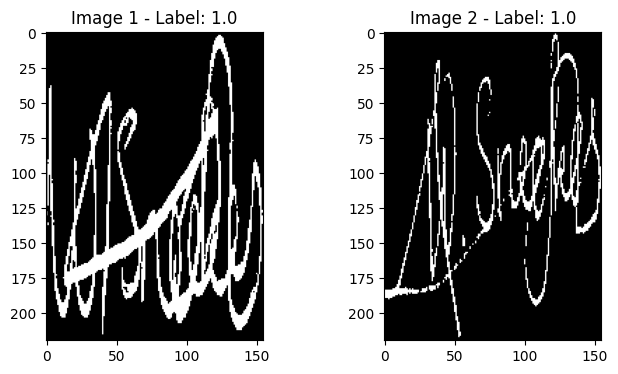

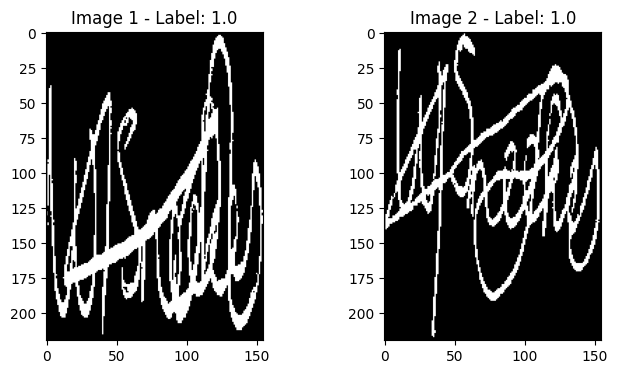

In [ ]:
display_img(test_data_generator,count=1)

In [ ]:
test_pred=model.predict(test_data_generator)

90/90 [==============================] - 85s 948ms/step


In [ ]:
len(labels_test)

5748

In [ ]:
print(f'accuracy:{evaluate(test_pred,labels_test)}')

accuracy:(0.7684899106270073, 0.3319645725935698)


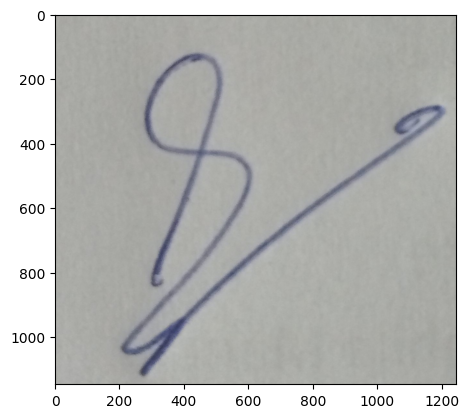

In [ ]:
test_img=cv.imread('/IMG20230920225529_BURST001_COVER.jpg')
test_img=cv.cvtColor(test_img,cv.COLOR_BGR2RGB)
plt.imshow(test_img)

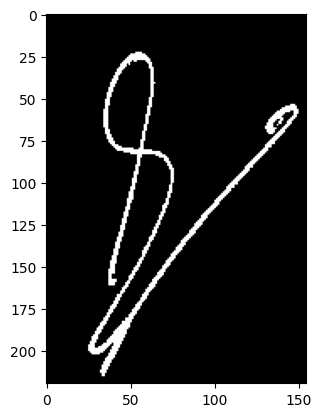

In [ ]:
image=cv.cvtColor(test_img,cv.COLOR_BGR2RGB)
image = cv.resize(image, (155,220))
image=cv.cvtColor(image,cv.COLOR_RGB2GRAY)
_,image=cv.threshold(image,128,255,cv.THRESH_OTSU+cv.THRESH_BINARY_INV)
image = image / np.std(image)
plt.imshow(image,cmap='gray')

In [ ]:
batch_size = 1
image_size = (155, 220)  # Set the desired image size
test_generator = SiameseDataGenerator(test_path,labels_test, batch_size, image_size)

In [ ]:
test_path=[('/IMG20230920225529_BURST001_COVER.jpg','/IMG20230920225529_BURST001_COVER.jpg')]

In [ ]:
model.predict(test_generator)

1/1 [==============================] - 1s 1s/step


array([[0.00031623]], dtype=float32)

In [ ]:
original='/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg'

In [ ]:
dir='/content/drive/MyDrive/Test/Forged'
files=os.listdir(dir)
files=[os.path.join(dir,f) for f in files]
files

['/content/drive/MyDrive/Test/Forged/IMG20230920225529.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230921142658.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230921142657.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230921142656.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230921142655.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230921142654.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230921142659.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230920225529_BURST001_COVER.jpg',
 '/content/drive/MyDrive/Test/Forged/IMG20230921150831.jpg']

In [ ]:
data_test=[(original,f) for f in files]
data_test
labels_t=[1,1,1,1,1,1,1,0,0]

In [ ]:
batch_size = 1
image_size = (155, 220)  # Set the desired image size
test_generator = SiameseDataGenerator(data_test,labels_t, batch_size, image_size)

(2, 1, 220, 155)


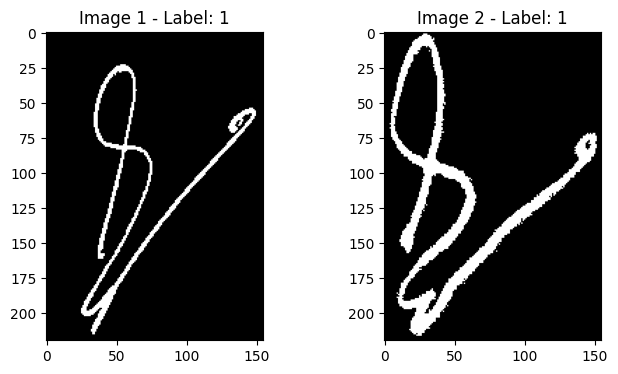

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


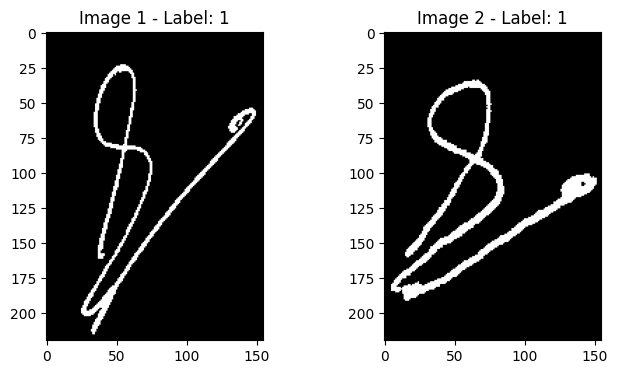

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


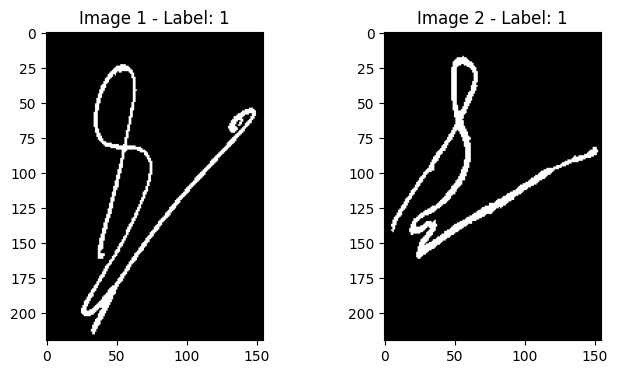

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


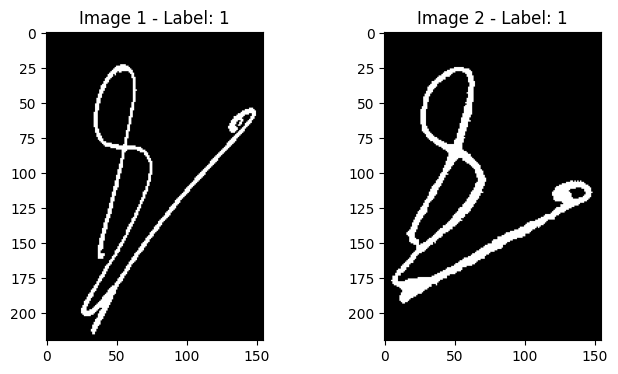

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


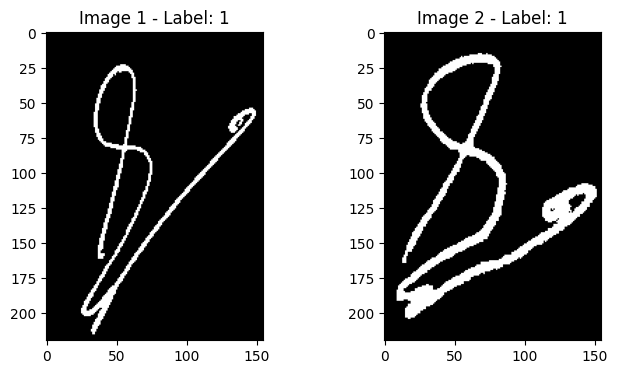

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


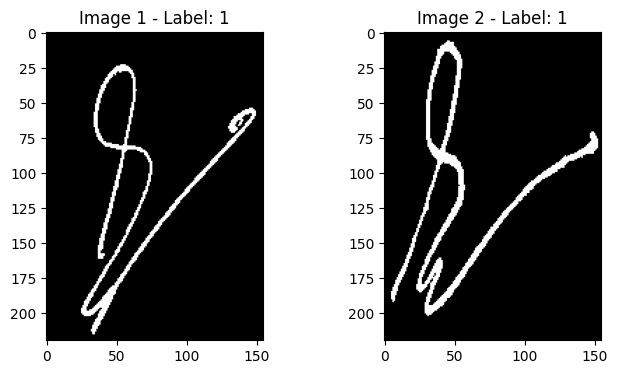

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


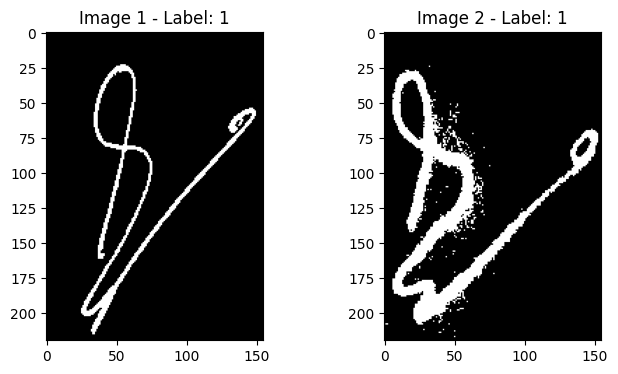

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


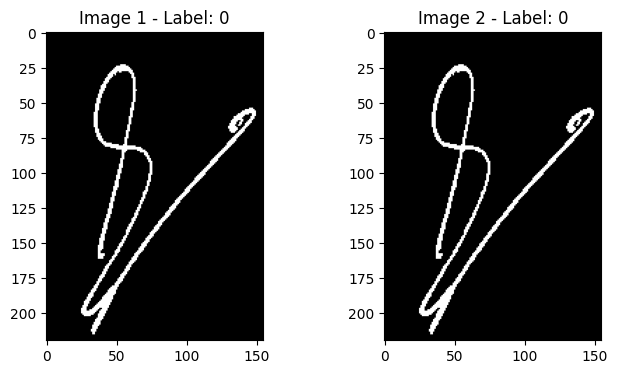

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


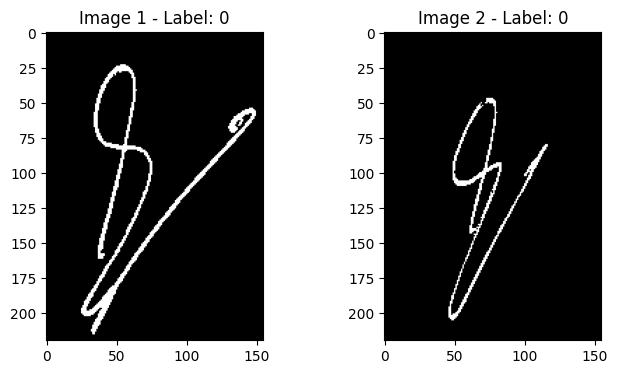

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)


In [ ]:
display_img(test_generator,count=7)

In [ ]:
predictions=model.predict(test_generator)

9/9 [==============================] - 1s 58ms/step


In [ ]:
evaluate(predictions,labels_t)

(0.7857142857142857, 0.2903162277571391)

In [ ]:
print(predictions)

[[6.9976056e-01]
 [3.9646846e-01]
 [8.9553148e-02]
 [1.1479151e-01]
 [2.8056318e-01]
 [3.2396778e-01]
 [7.1513689e-01]
 [3.1622776e-04]
 [2.8408471e-01]]


In [ ]:
pred=[]
for vals in predictions:
      if vals<=0.2903162277571391:pred.append(0)
      else:pred.append(1)
pred

[1, 1, 0, 0, 0, 1, 1, 0, 0]

In [ ]:
def create_pair_images(path_original,path_pair,filepath_ori,filepath_pair,labels):
    pair_img=[]
    label=[]
    with tf.device('/CPU:0'):
        for original,pair,l in zip(filepath_ori, filepath_pair,labels):
            path_ori=path_original+'/'+original
            img1=cv.imread(path_ori)
            img1=cv.cvtColor(img1,cv.COLOR_BGR2RGB)
            img1=cv.resize(img1,(155,220))
            img1=np.array(img1)
            img1=img1.astype('float32')
            img1/=255.0

            path_pa=path_pair+'/'+pair
            img2=cv.imread(path_pa)
            img2=cv.cvtColor(img2,cv.COLOR_BGR2RGB)
            img2=cv.resize(img2,(155,220))
            img2=np.array(img2)
            img2=img2.astype('float32')
            img2/=255.0

            pair_img+=[[img1,img2]]
            label.append(l)

    return np.array(pair_img), np.array(label)

In [ ]:
train_pair,label=create_pair_images(path,path_pair,filepath,filepath_pair,label)

In [ ]:
y_train=np.array(y_train)
y_val=np.array(y_val)

In [ ]:
y_train.shape

In [ ]:
data_test.shape

(5748, 3)

In [ ]:
originals_test=data_test["Item 1"]
pairs_test=data_test["Item 2"]
labels_test=data_test["Label"]

In [ ]:
np.array(originals_test)
np.array(pairs_test)

array(['068_forg/03_0113068.PNG', '068_forg/01_0124068.PNG',
       '068_forg/02_0124068.PNG', ..., '066/02_066.png', '066/05_066.png',
       '066/11_066.png'], dtype=object)

In [ ]:
path_test=r"C:/Users/Shirshak/Tensorflow Tutorials/Seiamese network/sign_data/test"

In [ ]:
path_test=r"C:/Users/Shirshak/Tensorflow Tutorials/Seiamese network/sign_data/test"
folder=[]
filepath=[]
for original in originals:
    old_path=path+'/'+original
    head_tail=os.path.split(old_path)
    folder.append(head_tail[0])
    filepath.append(head_tail[1])

In [ ]:
test_pair,label=create_pair_images(path_test,path_test,originals_test,pairs_test,labels_test)

In [ ]:
img=cv.imread('C:/Users/Shirshak/Tensorflow Tutorials/Seiamese network/sign_data/test/068/09_068.png')

In [ ]:
X_test,y_test = train_test_split(test_pair,shuffle=False)

In [ ]:
import random

In [ ]:
with tf.device('/CPU:0'):
    test=model.evaluate(x=(test_pair[:,0],test_pair[:,1]),y=label,batch_size=128)

In [ ]:
l=model.predict((test_pair[:,0],test_pair[:,1]))